In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    log_loss, brier_score_loss, roc_auc_score
)
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

from venn_abers import VennAbersCalibrator


In [2]:
def _logit(p, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p) - np.log(1 - p)

def platt_fit_predict(s_cal, y_cal, s_test, l2=1e-6):
    z = _logit(s_cal)
    def nll(ab):
        A, B = ab
        p = 1.0 / (1.0 + np.exp(-(A * z + B)))
        return log_loss(y_cal, p) + l2 * (A*A + B*B)
    res = minimize(nll, x0=np.array([1.0, 0.0]), method="L-BFGS-B")
    A_opt, B_opt = res.x
    z_test = _logit(s_test)
    p_test = 1.0 / (1.0 + np.exp(-(A_opt * z_test + B_opt)))
    return p_test, (A_opt, B_opt, res)

def ece_quantile(y, p, n_bins=10):
    pt, pp = calibration_curve(y, p, n_bins=n_bins, strategy="quantile")
    return float(np.mean(np.abs(pt - pp))), pt, pp


In [3]:
def run_simulation(counts, title="Simulation"):
    rng = np.random.default_rng(42)

    # Class 0: Beta(2,8) + Gaussian noise
    probs_0 = rng.beta(2, 8, size=counts[0]) + rng.normal(0, 0.1, size=counts[0])
    probs_0 = np.clip(probs_0, 0, 1)

    # Class 1: Beta(8,2) + Gaussian noise
    probs_1 = rng.beta(8, 2, size=counts[1]) + rng.normal(0, 0.1, size=counts[1])
    probs_1 = np.clip(probs_1, 0, 1)

    df_sim = pd.DataFrame({
        "y": np.concatenate([np.zeros(counts[0], int), np.ones(counts[1], int)]),
        "proba": np.concatenate([probs_0, probs_1])
    }).sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"\n=== {title} ===")
    print(df_sim.groupby("y")["proba"].describe())

    # ---- Calibration split ----
    X_cal, X_test, y_cal, y_test = train_test_split(
        df_sim[["proba"]].values, df_sim["y"].values,
        test_size=0.3, stratify=df_sim["y"].values, random_state=42
    )
    s_cal, s_test = X_cal.ravel(), X_test.ravel()

    # ---- Platt ----
    p_platt_test, _ = platt_fit_predict(s_cal, y_cal, s_test)
    p_platt_cal, _  = platt_fit_predict(s_cal, y_cal, s_cal)

    # ---- Isotonic ----
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(s_cal, y_cal)
    p_iso_test, p_iso_cal = iso.predict(s_test), iso.predict(s_cal)

    # ---- Venn-Abers ----
    p_cal_2d  = np.column_stack([1 - s_cal,  s_cal])
    p_test_2d = np.column_stack([1 - s_test, s_test])
    va = VennAbersCalibrator()
    p_va_test = va.predict_proba(p_cal=p_cal_2d, y_cal=y_cal,
                                 p_test=p_test_2d, p0_p1_output=False)[:,1]
    p_va_cal = va.predict_proba(p_cal=p_cal_2d, y_cal=y_cal,
                                p_test=p_cal_2d, p0_p1_output=False)[:,1]

    # ---- Results ----
    methods_test = {
        "Raw": s_test,
        "Platt": p_platt_test,
        "Isotonic": p_iso_test,
        "Venn-Abers-IVAP": p_va_test,
    }
    methods_cal = {
        "Raw": s_cal,
        "Platt": p_platt_cal,
        "Isotonic": p_iso_cal,
        "Venn-Abers-IVAP": p_va_cal,
    }

    def evaluate(methods, y, setname):
        rows = []
        for name, p in methods.items():
            ece, _, _ = ece_quantile(y, p, n_bins=10)
            rows.append({
                "Method": name,
                "LogLoss": log_loss(y, p),
                "Brier": brier_score_loss(y, p),
                "ROC_AUC": roc_auc_score(y, p),
                "ECE": ece,
            })
        df = pd.DataFrame(rows).set_index("Method").round(4)
        print(f"\nCalibration Metrics ({setname} set):")
        display(df)

    # --- Metrics ---
    evaluate(methods_cal,  y_cal,  "Calibration")
    evaluate(methods_test, y_test, "Test")

    # --- Calibration curves: CAL set ---
    plt.figure(figsize=(6,6))
    for name, p in methods_cal.items():
        _, pt, pp = ece_quantile(y_cal, p, n_bins=10)
        plt.plot(pp, pt, marker='o', label=name)
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curves (Calibration set) - {title}")
    plt.legend(); plt.grid(True); plt.show()

    # --- Calibration curves: TEST set ---
    plt.figure(figsize=(6,6))
    for name, p in methods_test.items():
        _, pt, pp = ece_quantile(y_test, p, n_bins=10)
        plt.plot(pp, pt, marker='o', label=name)
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curves (Test set) - {title}")
    plt.legend(); plt.grid(True); plt.show()



=== Original imbalance ===
     count      mean       std       min       25%       50%       75%  \
y                                                                        
0  25473.0  0.204748  0.148538  0.000000  0.089407  0.187489  0.298517   
1   7108.0  0.796708  0.148297  0.133415  0.702143  0.813171  0.912657   

        max  
y            
0  0.934986  
1  1.000000  

Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2491,0.0638,0.9932,0.1690
Platt,0.0831,0.0234,0.9932,0.0015
Isotonic,0.0809,0.0230,0.9934,0.0000
Venn-Abers-IVAP,0.0816,0.0230,0.9934,0.0018



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2493,0.0638,0.9939,0.1710
Platt,0.0794,0.0225,0.9939,0.0027
Isotonic,0.0798,0.0226,0.9938,0.0016
Venn-Abers-IVAP,0.0797,0.0225,0.9939,0.0026


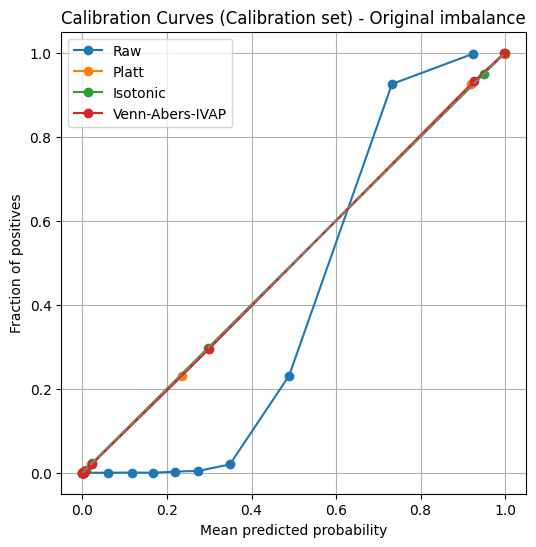

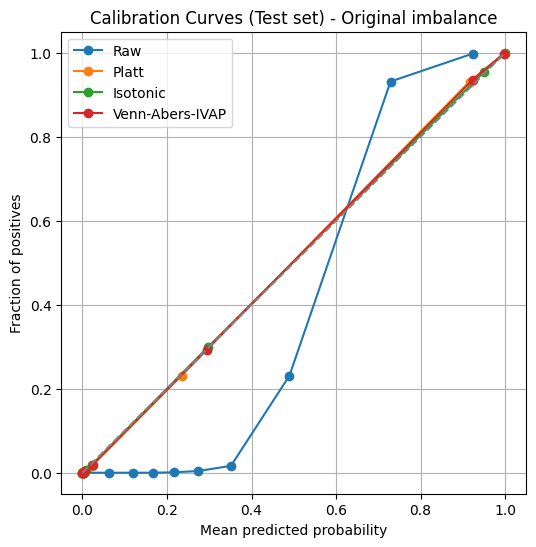


=== Balanced classes ===
     count      mean       std       min       25%       50%       75%  \
y                                                                        
0  10000.0  0.203402  0.147208  0.000000  0.088814  0.188531  0.295368   
1  10000.0  0.792127  0.149098  0.087974  0.697754  0.809323  0.906725   

        max  
y            
0  0.877611  
1  1.000000  

Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2518,0.0647,0.9932,0.1618
Platt,0.1033,0.0288,0.9932,0.0029
Isotonic,0.0997,0.0282,0.9935,0.0000
Venn-Abers-IVAP,0.1007,0.0282,0.9934,0.0026



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2479,0.0632,0.9935,0.1626
Platt,0.1005,0.0279,0.9935,0.0070
Isotonic,0.1012,0.0279,0.9933,0.0061
Venn-Abers-IVAP,0.1014,0.0280,0.9934,0.0048


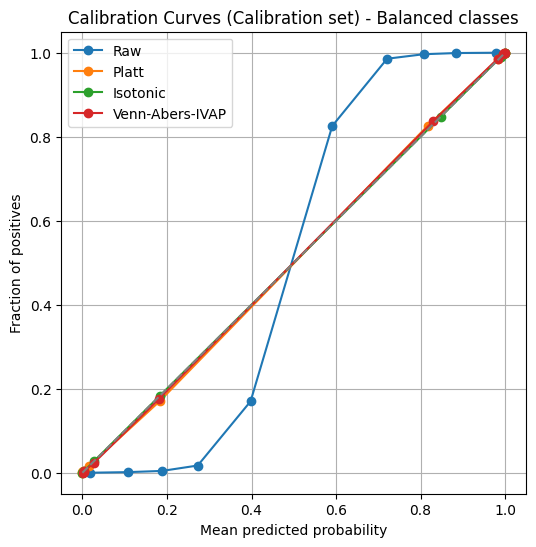

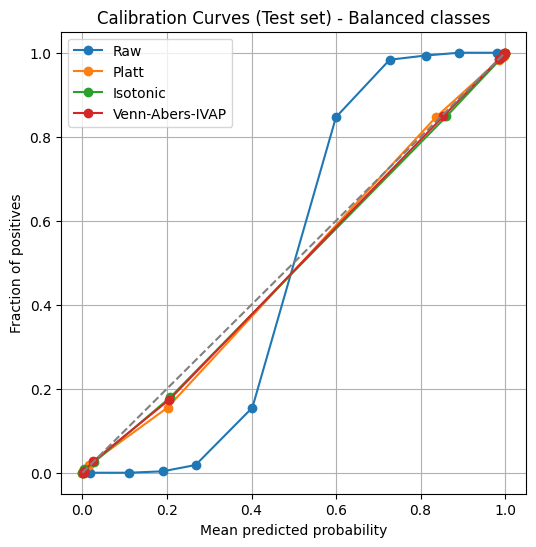


=== Reversed imbalance ===
     count      mean       std       min       25%       50%       75%  \
y                                                                        
0   7108.0  0.204287  0.148768  0.000000  0.088583  0.189636  0.296320   
1  25473.0  0.795638  0.148867  0.092238  0.700771  0.812642  0.911346   

       max  
y           
0  0.89738  
1  1.00000  

Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2483,0.0635,0.9931,0.1674
Platt,0.0840,0.0235,0.9931,0.0021
Isotonic,0.0816,0.0231,0.9934,0.0000
Venn-Abers-IVAP,0.0822,0.0231,0.9933,0.0018



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2515,0.0648,0.9927,0.1700
Platt,0.0856,0.0241,0.9927,0.0028
Isotonic,0.0858,0.0243,0.9925,0.0039
Venn-Abers-IVAP,0.0861,0.0243,0.9926,0.0043


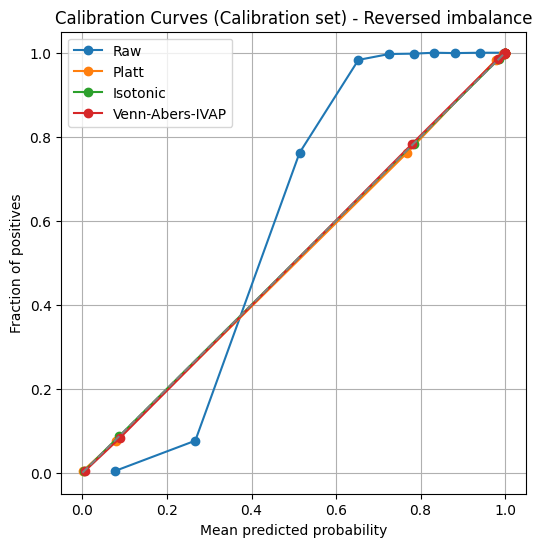

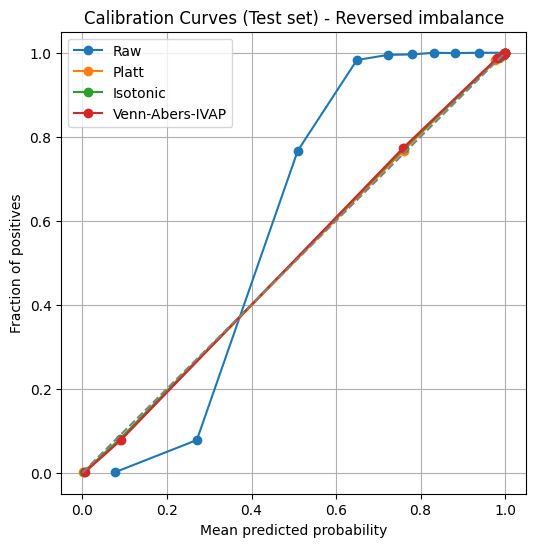

In [4]:
# Original distribution (imbalanced)
run_simulation({0: 25473, 1: 7108}, title="Original imbalance")

# Balanced (equal classes)
run_simulation({0: 10000, 1: 10000}, title="Balanced classes")

# Reversed imbalance (1 >> 0)
run_simulation({0: 7108, 1: 25473}, title="Reversed imbalance")
